In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import aparent.visualization as vis

from aparent.predictor import *

import urllib
import urllib.request
import pickle
from time import sleep

from scipy.stats import ttest_ind
from scipy.stats import pearsonr, spearmanr

from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve, roc_auc_score

from scipy.optimize import minimize


Using TensorFlow backend.


In [3]:

df = pd.read_csv('../../../aparent/data/polyadb_features_pas_3_utr3_perturb.csv', sep='\t')

save_dict = np.load("../../../aparent/data/polyadb_features_pas_3_utr3_perturb_no_x.npz", allow_pickle=True)
m, ids, l, c, y = save_dict['m'], save_dict['ids'], save_dict['l'], save_dict['c'], save_dict['y']

s = np.load('../predictions/apa_perturb_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_utr3_native_scores.npy')

#Mark intronic sites
intron_mask = np.zeros(m.shape)
for k in range(m.shape[1]) :
    intron_mask[:, k] = np.array((df['pas_exists_' + str(k)] & df['site_type_' + str(k)].isin(['Intron', 'Internal_exon'])).astype(int).values, dtype=np.int32)

print("s.shape = " + str(s.shape))
print("ids.shape = " + str(ids.shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("c.shape = " + str(c.shape))
print("y.shape = " + str(y.shape))
print("intron_mask.shape = " + str(intron_mask.shape))


s.shape = (5267, 10)
ids.shape = (5267, 10)
m.shape = (5267, 10)
l.shape = (5267, 10)
c.shape = (5267, 10, 28)
y.shape = (5267, 10, 28)
intron_mask.shape = (5267, 10)


In [3]:
#Define tissue-/cell- types

cell_types = np.array([
    'rpm',
    'NT',
    'CDC73',
    'CPSF1',
    'CPSF2',
    'CPSF3',
    'CPSF3L',
    'CPSF4',
    'CPSF6',
    'CSTF1',
    'CSTF3',
    'CTR9',
    'FIP1L1',
    'LEO1',
    'NUDT21',
    'PABPC1',
    'PABPN1',
    'PAF1',
    'PAPOLA',
    'PCF11',
    'RBBP6',
    'RPRD1A',
    'RPRD1B',
    'SCAF8',
    'SF3A1',
    'SRSF3',
    'SYMPK',
    'THOC5'
], dtype=np.object)

cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(cell_types)
}

#Slice celltypes (and apply filters)

'''
CDC73
CTR9
LEO1
PAF1
'''

cell_type_1 = 'NT'
cell_type_2 = 'PAF1'#'PAF1'

min_c_1 = 10.
min_c_2 = 10.

min_total_l = 300
max_total_l = 1e6

min_l = np.min(l + (l == 0.) * 1e6, axis=-1)
max_l = np.max(l, axis=-1)

c_1 = c[:, :, cell_type_dict[cell_type_1]]
y_1 = y[:, :, cell_type_dict[cell_type_1]]

c_2 = c[:, :, cell_type_dict[cell_type_2]]
y_2 = y[:, :, cell_type_dict[cell_type_2]]

keep_index = np.nonzero((intron_mask[:, 0] <= 1.) & ((((min_l >= min_total_l) & (max_l <= max_total_l)) & ((np.sum(c_1, axis=-1) >= min_c_1) & (np.sum(c_2, axis=-1) >= min_c_2))) & (((y_1[:, 0] > 0.) & (y_1[:, 0] < 1.)) & ((y_2[:, 0] > 0.) & (y_2[:, 0] < 1.)))))[0]

s = s[keep_index, :]
m = m[keep_index, :]
l = l[keep_index, :]
c_1 = c_1[keep_index, :]
y_1 = y_1[keep_index, :]
c_2 = c_2[keep_index, :]
y_2 = y_2[keep_index, :]
intron_mask = intron_mask[keep_index, :]

print("s.shape = " + str(s.shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("c_1.shape = " + str(c_1.shape))
print("y_1.shape = " + str(y_1.shape))
print("c_2.shape = " + str(c_2.shape))
print("y_2.shape = " + str(y_2.shape))
print("intron_mask.shape = " + str(intron_mask.shape))


s.shape = (4607, 10)
m.shape = (4607, 10)
l.shape = (4607, 10)
c_1.shape = (4607, 10)
y_1.shape = (4607, 10)
c_2.shape = (4607, 10)
y_2.shape = (4607, 10)
intron_mask.shape = (4607, 10)


In [4]:

l_prox_cumulative = np.log(np.cumsum(l[:, ::-1], axis=1) * m[:, ::-1] + 1.)[:, ::-1]
l_cumulative = np.log(np.cumsum(l, axis=1) * m + 1.)
l = np.log(l * m + 1.)


In [5]:

prox_index = np.array([np.nonzero(m[i, :])[0][0] for i in range(m.shape[0])])
dist_index = np.array([np.nonzero(m[i, :])[0][-1] for i in range(m.shape[0])])

prox_mask = np.zeros(m.shape)
for i in range(m.shape[0]) :
    prox_mask[i, prox_index[i]] = 1.

dist_mask = np.zeros(m.shape)
for i in range(m.shape[0]) :
    dist_mask[i, dist_index[i]] = 1.


In [6]:

y_1_prox = []
y_2_prox = []
for i in range(s.shape[0]) :
    y_1_prox.append(y_1[i, prox_index[i]])
    y_2_prox.append(y_2[i, prox_index[i]])

y_1_prox = np.array(y_1_prox)
y_2_prox = np.array(y_2_prox)

logodds_1_prox = np.log(y_1_prox / (1. - y_1_prox))
logodds_2_prox = np.log(y_2_prox / (1. - y_2_prox))

lor_prox = logodds_2_prox - logodds_1_prox


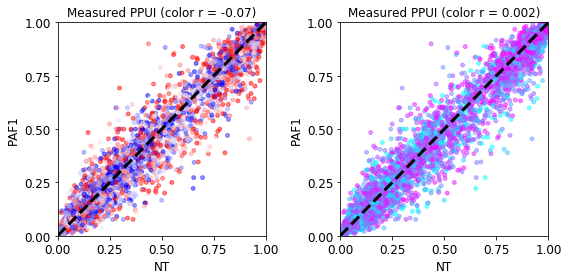

In [7]:
#3' UTR sites only

from scipy.stats import spearmanr, pearsonr

f, ax = plt.subplots(1, 2, figsize=(8, 4))

plt.sca(ax[0])

y_pred = l[:, 1]

r_val, _ = spearmanr(y_pred, lor_prox)

low_qtl = np.quantile(y_pred, q=0.1)
high_qtl = np.quantile(y_pred, q=0.9)

plt.scatter(y_1_prox, y_2_prox, cmap='bwr', c=y_pred, vmin=low_qtl, vmax=high_qtl, s=15, alpha=0.5)

plt.plot([0, 1], [0, 1], color='black', linewidth=3, linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)

plt.xlabel(cell_type_1, fontsize=12)
plt.ylabel(cell_type_2, fontsize=12)

plt.title("Measured PPUI (color r = " + str(round(r_val, 3)) + ")", fontsize=12)


plt.sca(ax[1])

y_pred = s[:, 0]

r_val, _ = spearmanr(y_pred, lor_prox)

low_qtl = np.quantile(y_pred, q=0.1)
high_qtl = np.quantile(y_pred, q=0.9)

plt.scatter(y_1_prox, y_2_prox, cmap='cool', c=y_pred, vmin=low_qtl, vmax=high_qtl, s=15, alpha=0.5)

plt.plot([0, 1], [0, 1], color='black', linewidth=3, linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)

plt.xlabel(cell_type_1, fontsize=12)
plt.ylabel(cell_type_2, fontsize=12)

plt.title("Measured PPUI (color r = " + str(round(r_val, 3)) + ")", fontsize=12)

plt.tight_layout()

plt.show()
